In [1]:
!pip install rembg
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.1 MB/s eta 0:00:00


In [2]:
!pip install pytesseract

In [3]:
import pytesseract
from pytesseract import Output

In [4]:
import cv2
import numpy as np
from PIL import Image
from rembg import remove
from matplotlib import pyplot as plt

## Scan VS Photo Detection

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def is_scan_final_smart(img_path, show_debug=False):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape

    mean_val = np.mean(gray)
    std_val = np.std(gray)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / (h * w)
    non_white_pixels = np.sum(gray < 250)
    content_ratio = non_white_pixels / (h * w)

    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
    peak_position = np.argmax(hist)
    peak_value = hist[peak_position]
    total_pixels = h * w

    if show_debug:
        print(f"📊 Moyenne : {mean_val:.2f}")
        print(f"📉 Écart-type : {std_val:.2f}")
        print(f"✏️ Densité des contours : {edge_density:.4f}")
        print(f"🧾 Ratio contenu (non-blanc) : {content_ratio:.4f}")
        print(f"🔦 Pic histogramme à : {peak_position} (valeur : {peak_value:.0f})")

    # VISUALISATION
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Image originale")
    axs[0].axis("off")
    axs[1].imshow(edges, cmap='gray')
    axs[1].set_title("Contours (Canny)")
    axs[1].axis("off")
    axs[2].hist(gray.ravel(), bins=256, range=[0, 256], color='gray')
    axs[2].set_title("Histogramme de luminosité")
    axs[2].set_xlabel("Niveau de gris")
    axs[2].set_ylabel("Pixels")
    plt.tight_layout()
    plt.show()

    # 🔐 Nouvelle heuristique + exception pour texte dense
    if (
        (mean_val > 200 and peak_position > 240) and
        (content_ratio > 0.05 or peak_value / total_pixels > 0.6)
    ):
        print("✅ Image détectée comme un **SCAN**")
        return "scan"
    else:
        print("📸 Image détectée comme une **PHOTO**")
        return "photo"

# Remove Background + Niveau De Gris


🚀 Traitement de l’image : /content/1111111.jpg
📊 Moyenne : 172.83
📉 Écart-type : 39.77
✏️ Densité des contours : 0.0286
🧾 Ratio contenu (non-blanc) : 0.9985
🔦 Pic histogramme à : 192 (valeur : 282629)


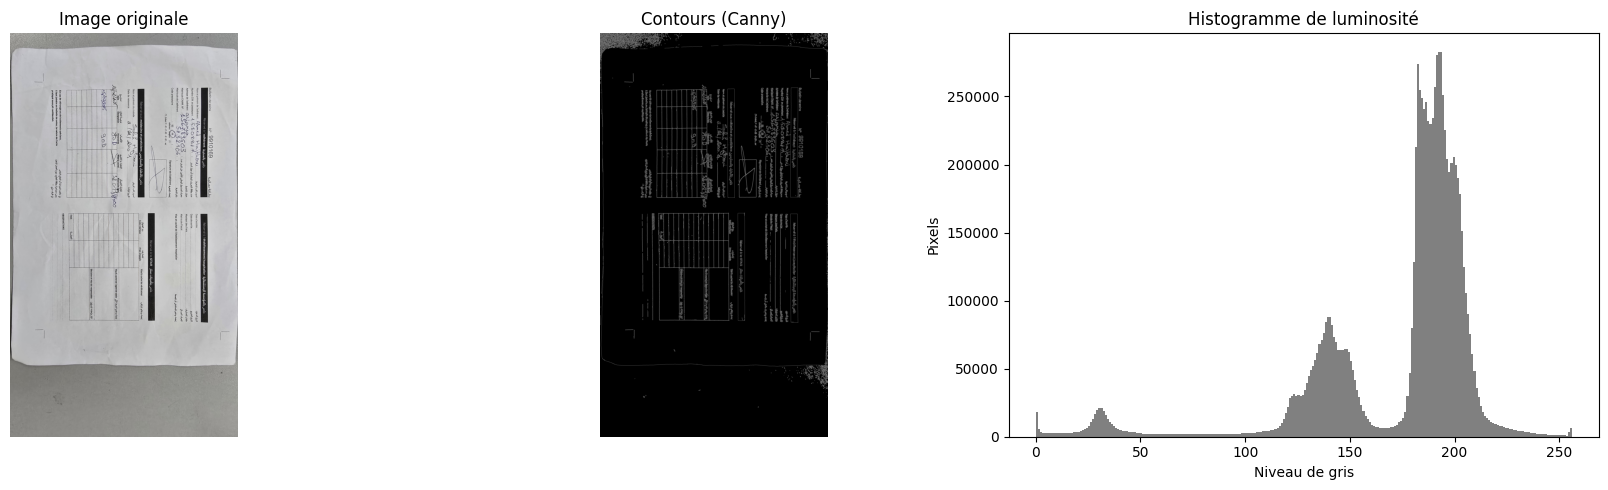

📸 Image détectée comme une **PHOTO**

🧠 Type détecté : PHOTO


100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 20.1GB/s]


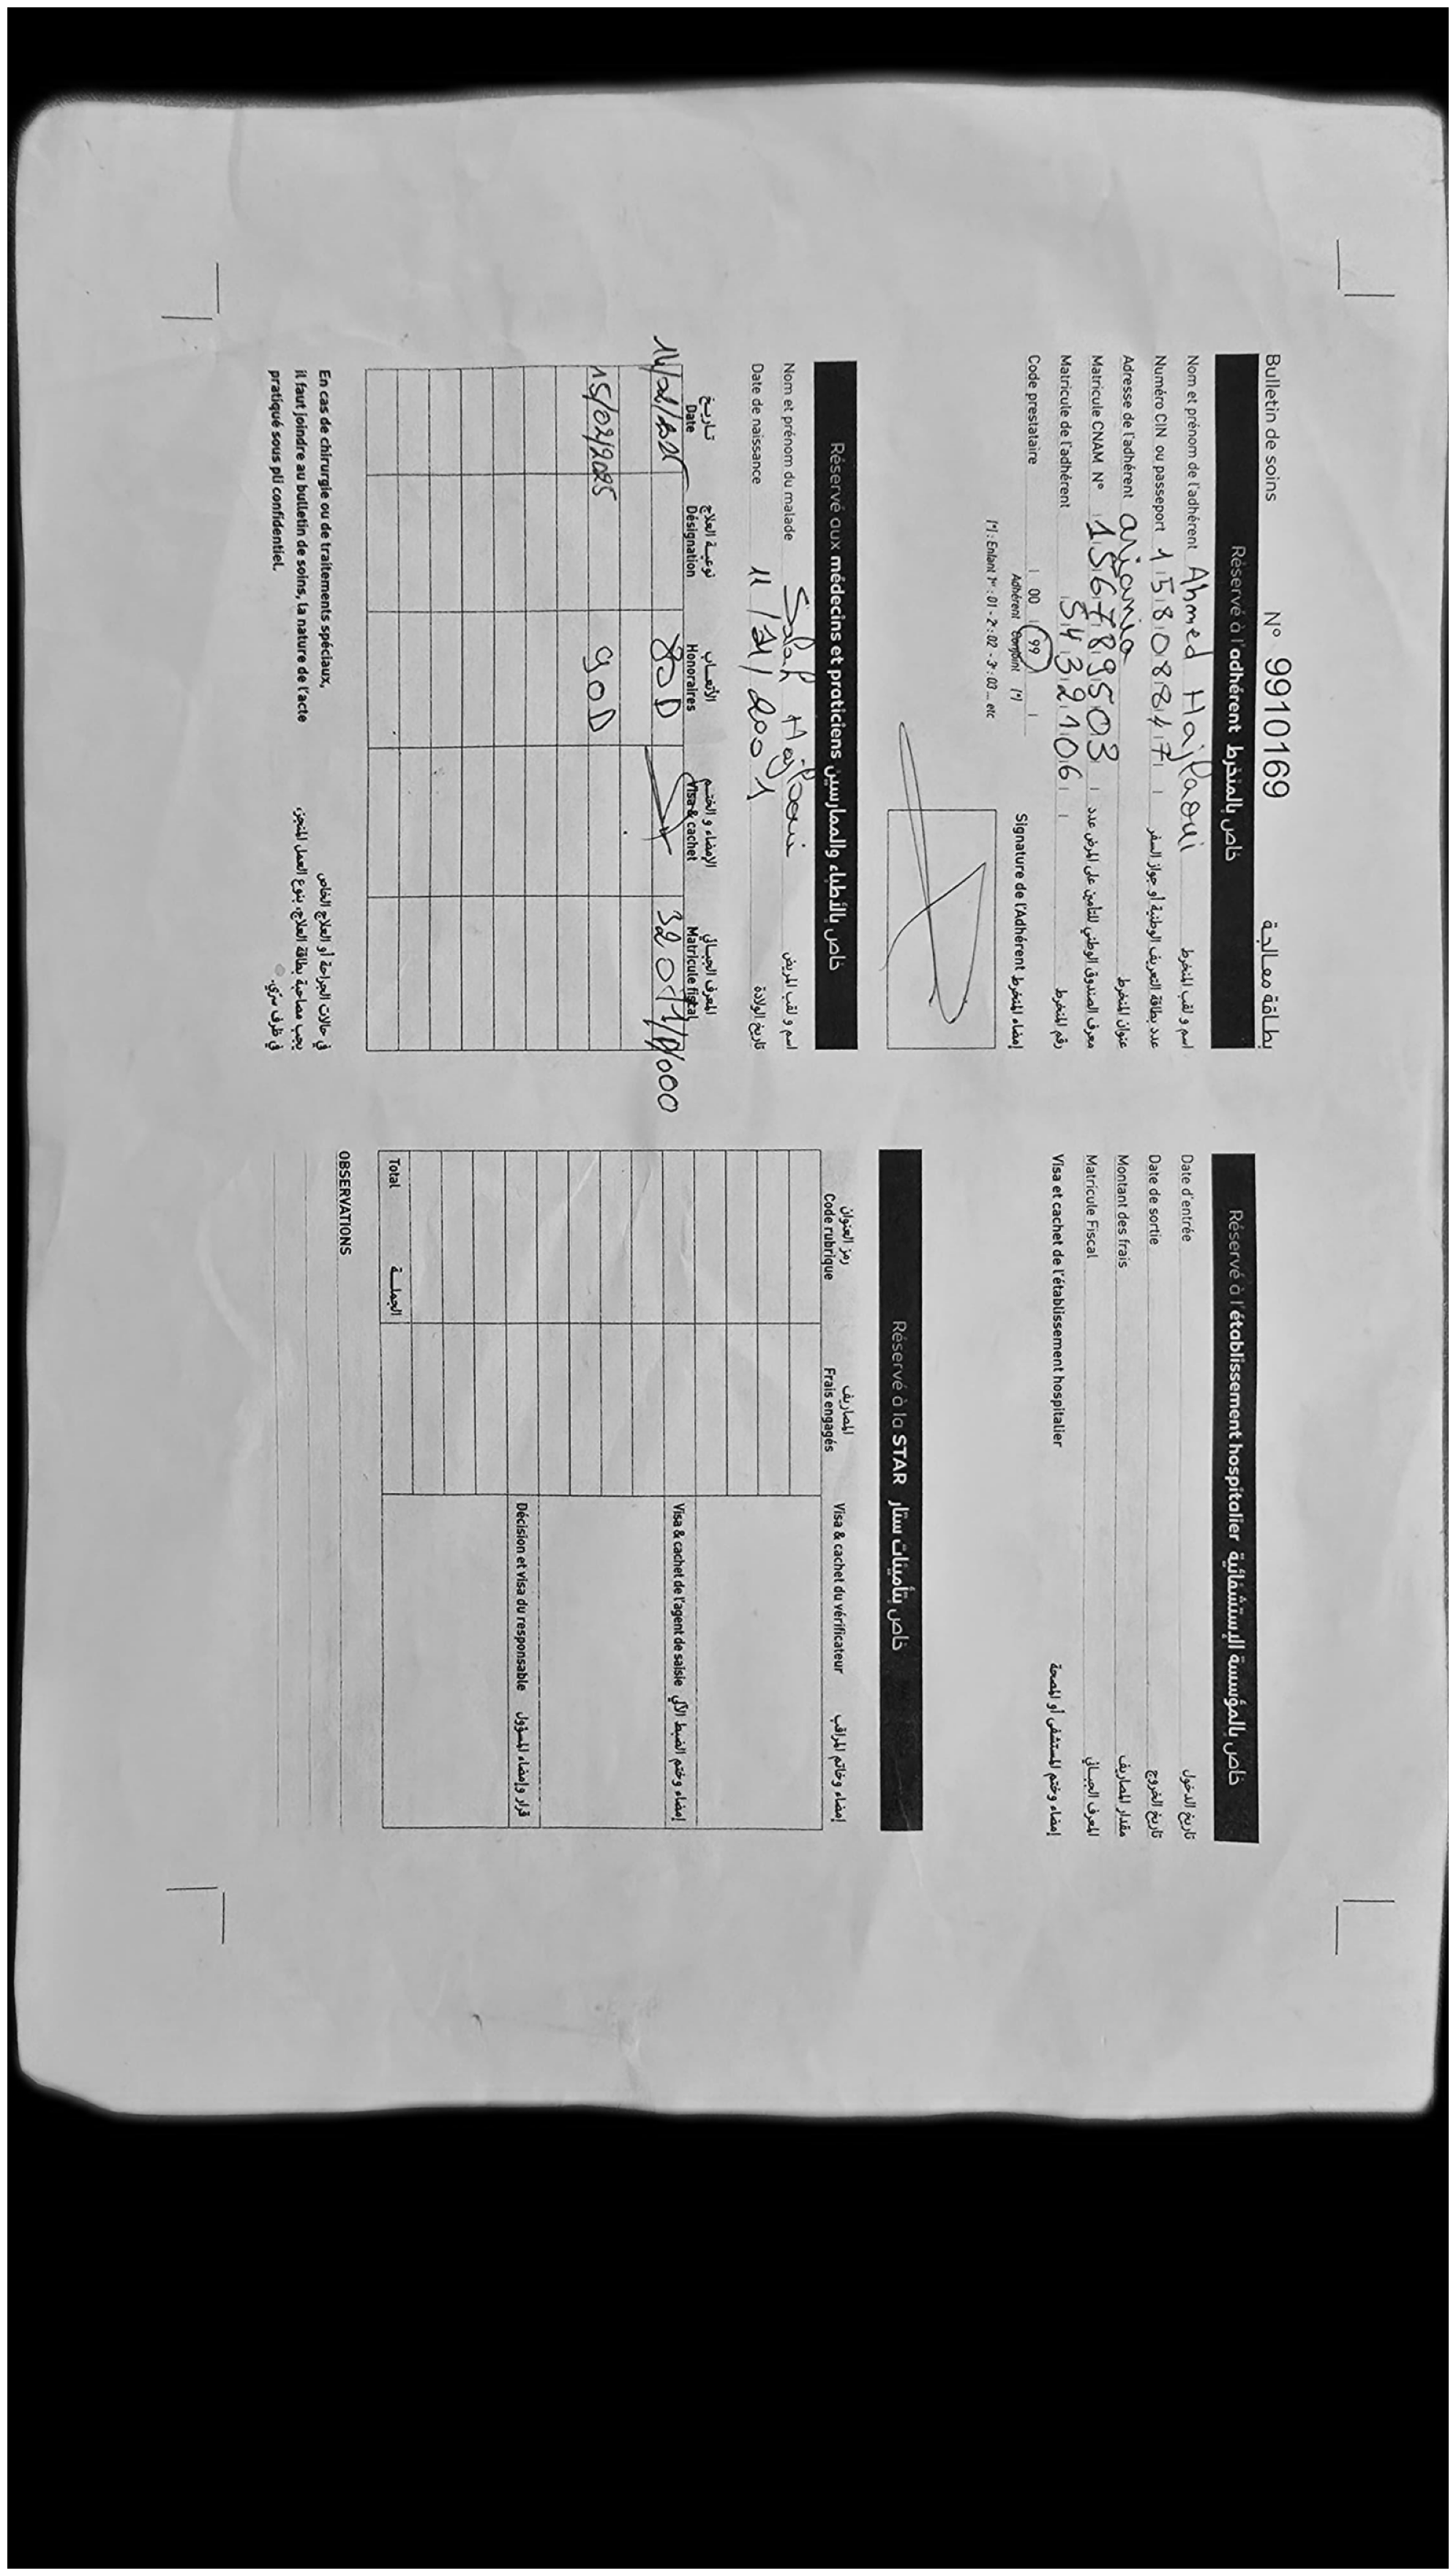

In [6]:
import cv2
import os
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt

# 🔍 Affichage de l’image traitée
def display(im_path, scale_percent=70):
    img = cv2.imread(im_path)
    new_width = int(img.shape[1] * scale_percent / 100)
    new_height = int(img.shape[0] * scale_percent / 100)
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    dpi = 80
    figsize = new_width / float(dpi), new_height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(resized_img_rgb, cmap='gray')
    plt.show()

# ✨ Traitement d’une image unique
def process_single_image(input_image_path, output_image_path):
    print(f"\n🚀 Traitement de l’image : {input_image_path}")

    image_type = is_scan_final_smart(input_image_path, show_debug=True)
    print(f"\n🧠 Type détecté : {image_type.upper()}")

    if image_type == "photo":
        # Suppression de fond si c’est une photo
        input_image = Image.open(input_image_path)
        output_image = remove(input_image)
        output_image = output_image.convert("RGB")  # This line was added
        output_image.save(output_image_path)

        # Conversion en niveaux de gris
        img = cv2.imread(output_image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(output_image_path, gray)

    else:
        # Si c’est un scan, juste conversion en niveaux de gris
        img = cv2.imread(input_image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(output_image_path, gray)

    # Affichage du résultat
    display(output_image_path)

# 🔽 Spécifie ici les chemins d’entrée et de sortie
input_path = "/content/1111111.jpg"
output_path = "image_apres_elimination_background.jpg"

# 🔁 Traitement
process_single_image(input_path, output_path)


# Correction d'inclinaison

In [7]:
!sudo apt install tesseract-ocr
!pip install pytesseract opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [8]:
import cv2
import numpy as np

def detect_and_correct_skew(img):
    # 1. S'assurer que l'image est en niveaux de gris
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # 2. Détection des bords
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # 3. Détection de segments avec HoughLinesP
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100,
                            minLineLength=50, maxLineGap=10)

    if lines is None or len(lines) == 0:
        print("❌ Aucune ligne détectée.")
        return img, 0

    angles = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 == x1:
            continue  # Ignore les lignes verticales parfaites
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        if -89 < angle < 89:
            angles.append(angle)

    if not angles:
        print("❌ Aucun angle significatif trouvé.")
        return img, 0

    # 4. Calcul de l'angle moyen
    average_angle = np.median(angles)
    print(f"✅ Inclinaison détectée : {average_angle:.2f}°")

    # 5. Calcul des nouvelles dimensions pour inclure toute l'image
    (h, w) = img.shape[:2]
    abs_cos = abs(np.cos(np.radians(average_angle)))
    abs_sin = abs(np.sin(np.radians(average_angle)))

    # Nouvelles largeur et hauteur pour accueillir l'image entière
    new_w = int(h * abs_sin + w * abs_cos)
    new_h = int(h * abs_cos + w * abs_sin)

    # 6. Ajuster la matrice de rotation
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, average_angle, 1.0)

    # Ajouter une translation pour centrer l'image dans le nouveau canevas
    M[0, 2] += (new_w - w) / 2
    M[1, 2] += (new_h - h) / 2

    # 7. Appliquer la rotation avec les nouvelles dimensions
    rotated = cv2.warpAffine(img, M, (new_w, new_h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    return rotated, average_angle

In [9]:
image = cv2.imread("image_apres_elimination_background.jpg", cv2.IMREAD_GRAYSCALE)  # Image déjà propre
corrected_img, angle = detect_and_correct_skew(image)
cv2.imwrite("image_apres_correction_inclinaison.jpg", corrected_img)

✅ Inclinaison détectée : 0.00°


True

# Correction d'orientation

In [10]:
def detect_text_orientation(img):
    try:
        osd = pytesseract.image_to_osd(img, config='--psm 0 -c min_characters_to_try=5', output_type=Output.DICT)
        angle = osd.get("rotate", 0)
        print(f"🧭 Rotation détectée (Tesseract): {angle}°")
        return angle
    except pytesseract.TesseractError as e:
        print(f"❌ Erreur Tesseract : {e}")
        return 0

In [11]:
def rotate_image(img, angle):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

In [12]:
import cv2
import numpy as np
import pytesseract

def correct_orientation_tesseract(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img

    # Increase DPI-like resolution for better OCR (simulate it with resizing)
    scale_percent = 200  # double the size
    width = int(gray.shape[1] * scale_percent / 100)
    height = int(gray.shape[0] * scale_percent / 100)
    gray_resized = cv2.resize(gray, (width, height), interpolation=cv2.INTER_LINEAR)

    # Use Tesseract OSD directly
    try:
        osd = pytesseract.image_to_osd(gray_resized, config='--psm 0')
        rotation = 0
        for line in osd.split('\n'):
            if 'Rotate:' in line:
                rotation = int(line.split(':')[-1].strip())
                break
        print(f"✅ Orientation détectée par Tesseract : {rotation}°")
    except pytesseract.TesseractError as e:
        print(f"❌ Erreur Tesseract : {e}")
        return img, 0
    except Exception as e:
        print(f"❌ Échec de la détection d'orientation : {e}")
        return img, 0

    if rotation != 0:
        # Dimensions
        h, w = img.shape[:2]
        center = (w / 2, h / 2)

        # Rotation matrix and new size
        M = cv2.getRotationMatrix2D(center, -rotation, 1.0)
        abs_cos = abs(M[0, 0])
        abs_sin = abs(M[0, 1])
        new_w = int(h * abs_sin + w * abs_cos)
        new_h = int(h * abs_cos + w * abs_sin)
        M[0, 2] += (new_w - w) / 2
        M[1, 2] += (new_h - h) / 2

        rotated = cv2.warpAffine(img, M, (new_w, new_h),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=(255, 255, 255))
        return rotated, rotation

    return img, 0

def preprocess_image(image_path):
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError("❌ Image non trouvée")

    print("🔍 Correction de l’orientation globale...")
    corrected, rotation = correct_orientation_tesseract(original)
    return corrected

if __name__ == "__main__":
    image_path = "image_apres_correction_inclinaison.jpg"
    try:
        result = preprocess_image(image_path)
        cv2.imwrite("image_apres_correction_inclinaison.jpg", result)
        print("✅ Image réorientée enregistrée.")
    except Exception as e:
        print(f"❌ Erreur lors du traitement : {e}")


🔍 Correction de l’orientation globale...
✅ Orientation détectée par Tesseract : 270°
✅ Image réorientée enregistrée.


In [13]:
image = cv2.imread("image_apres_correction_inclinaison.jpg", cv2.IMREAD_GRAYSCALE)  # Image déjà propre
corrected_img, angle = detect_and_correct_skew(image)
cv2.imwrite("image_orientate.jpg", corrected_img)

✅ Inclinaison détectée : 0.00°


True

In [14]:
image = cv2.imread("image_orientate.jpg", cv2.IMREAD_GRAYSCALE)  # Image déjà propre
corrected_img, angle = detect_and_correct_skew(image)
cv2.imwrite("image_corrigé_inclinaison_apres_orientation.jpg", corrected_img)

✅ Inclinaison détectée : 0.00°


True


🚀 Traitement de l’image : image_corrigé_inclinaison_apres_orientation.jpg
📊 Moyenne : 141.83
📉 Écart-type : 82.15
✏️ Densité des contours : 0.0239
🧾 Ratio contenu (non-blanc) : 0.9984
🔦 Pic histogramme à : 0 (valeur : 1812245)


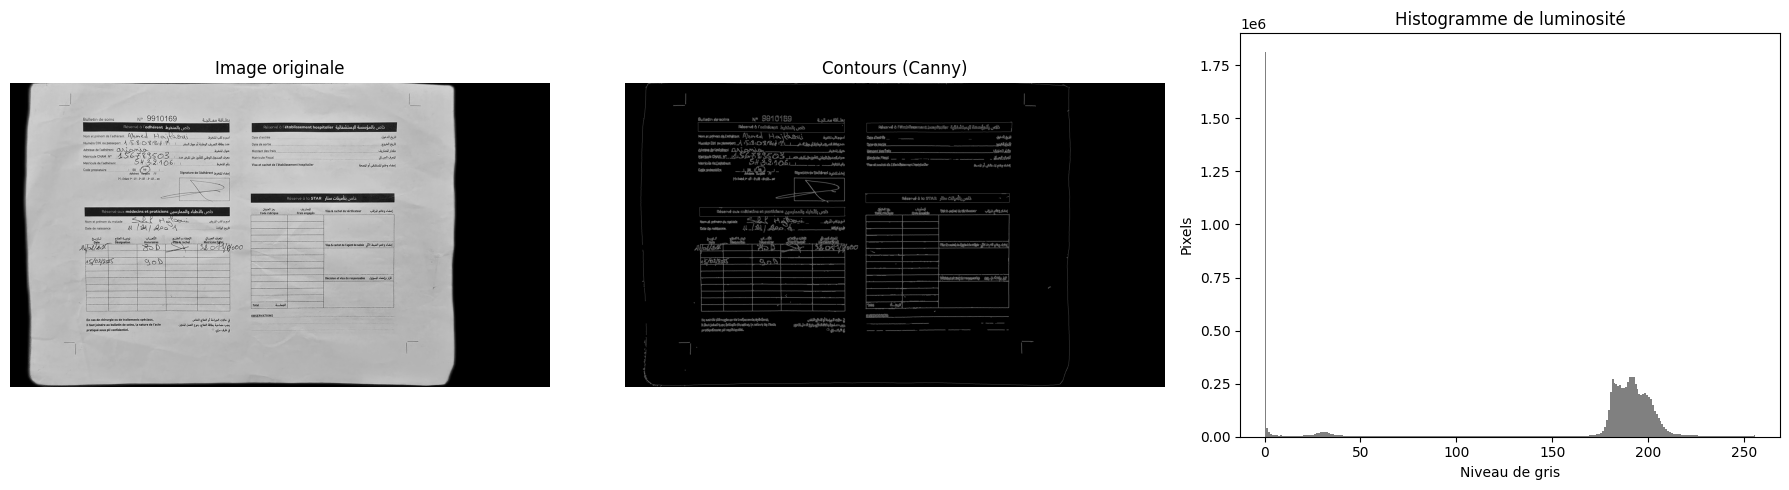

📸 Image détectée comme une **PHOTO**

🧠 Type détecté : PHOTO


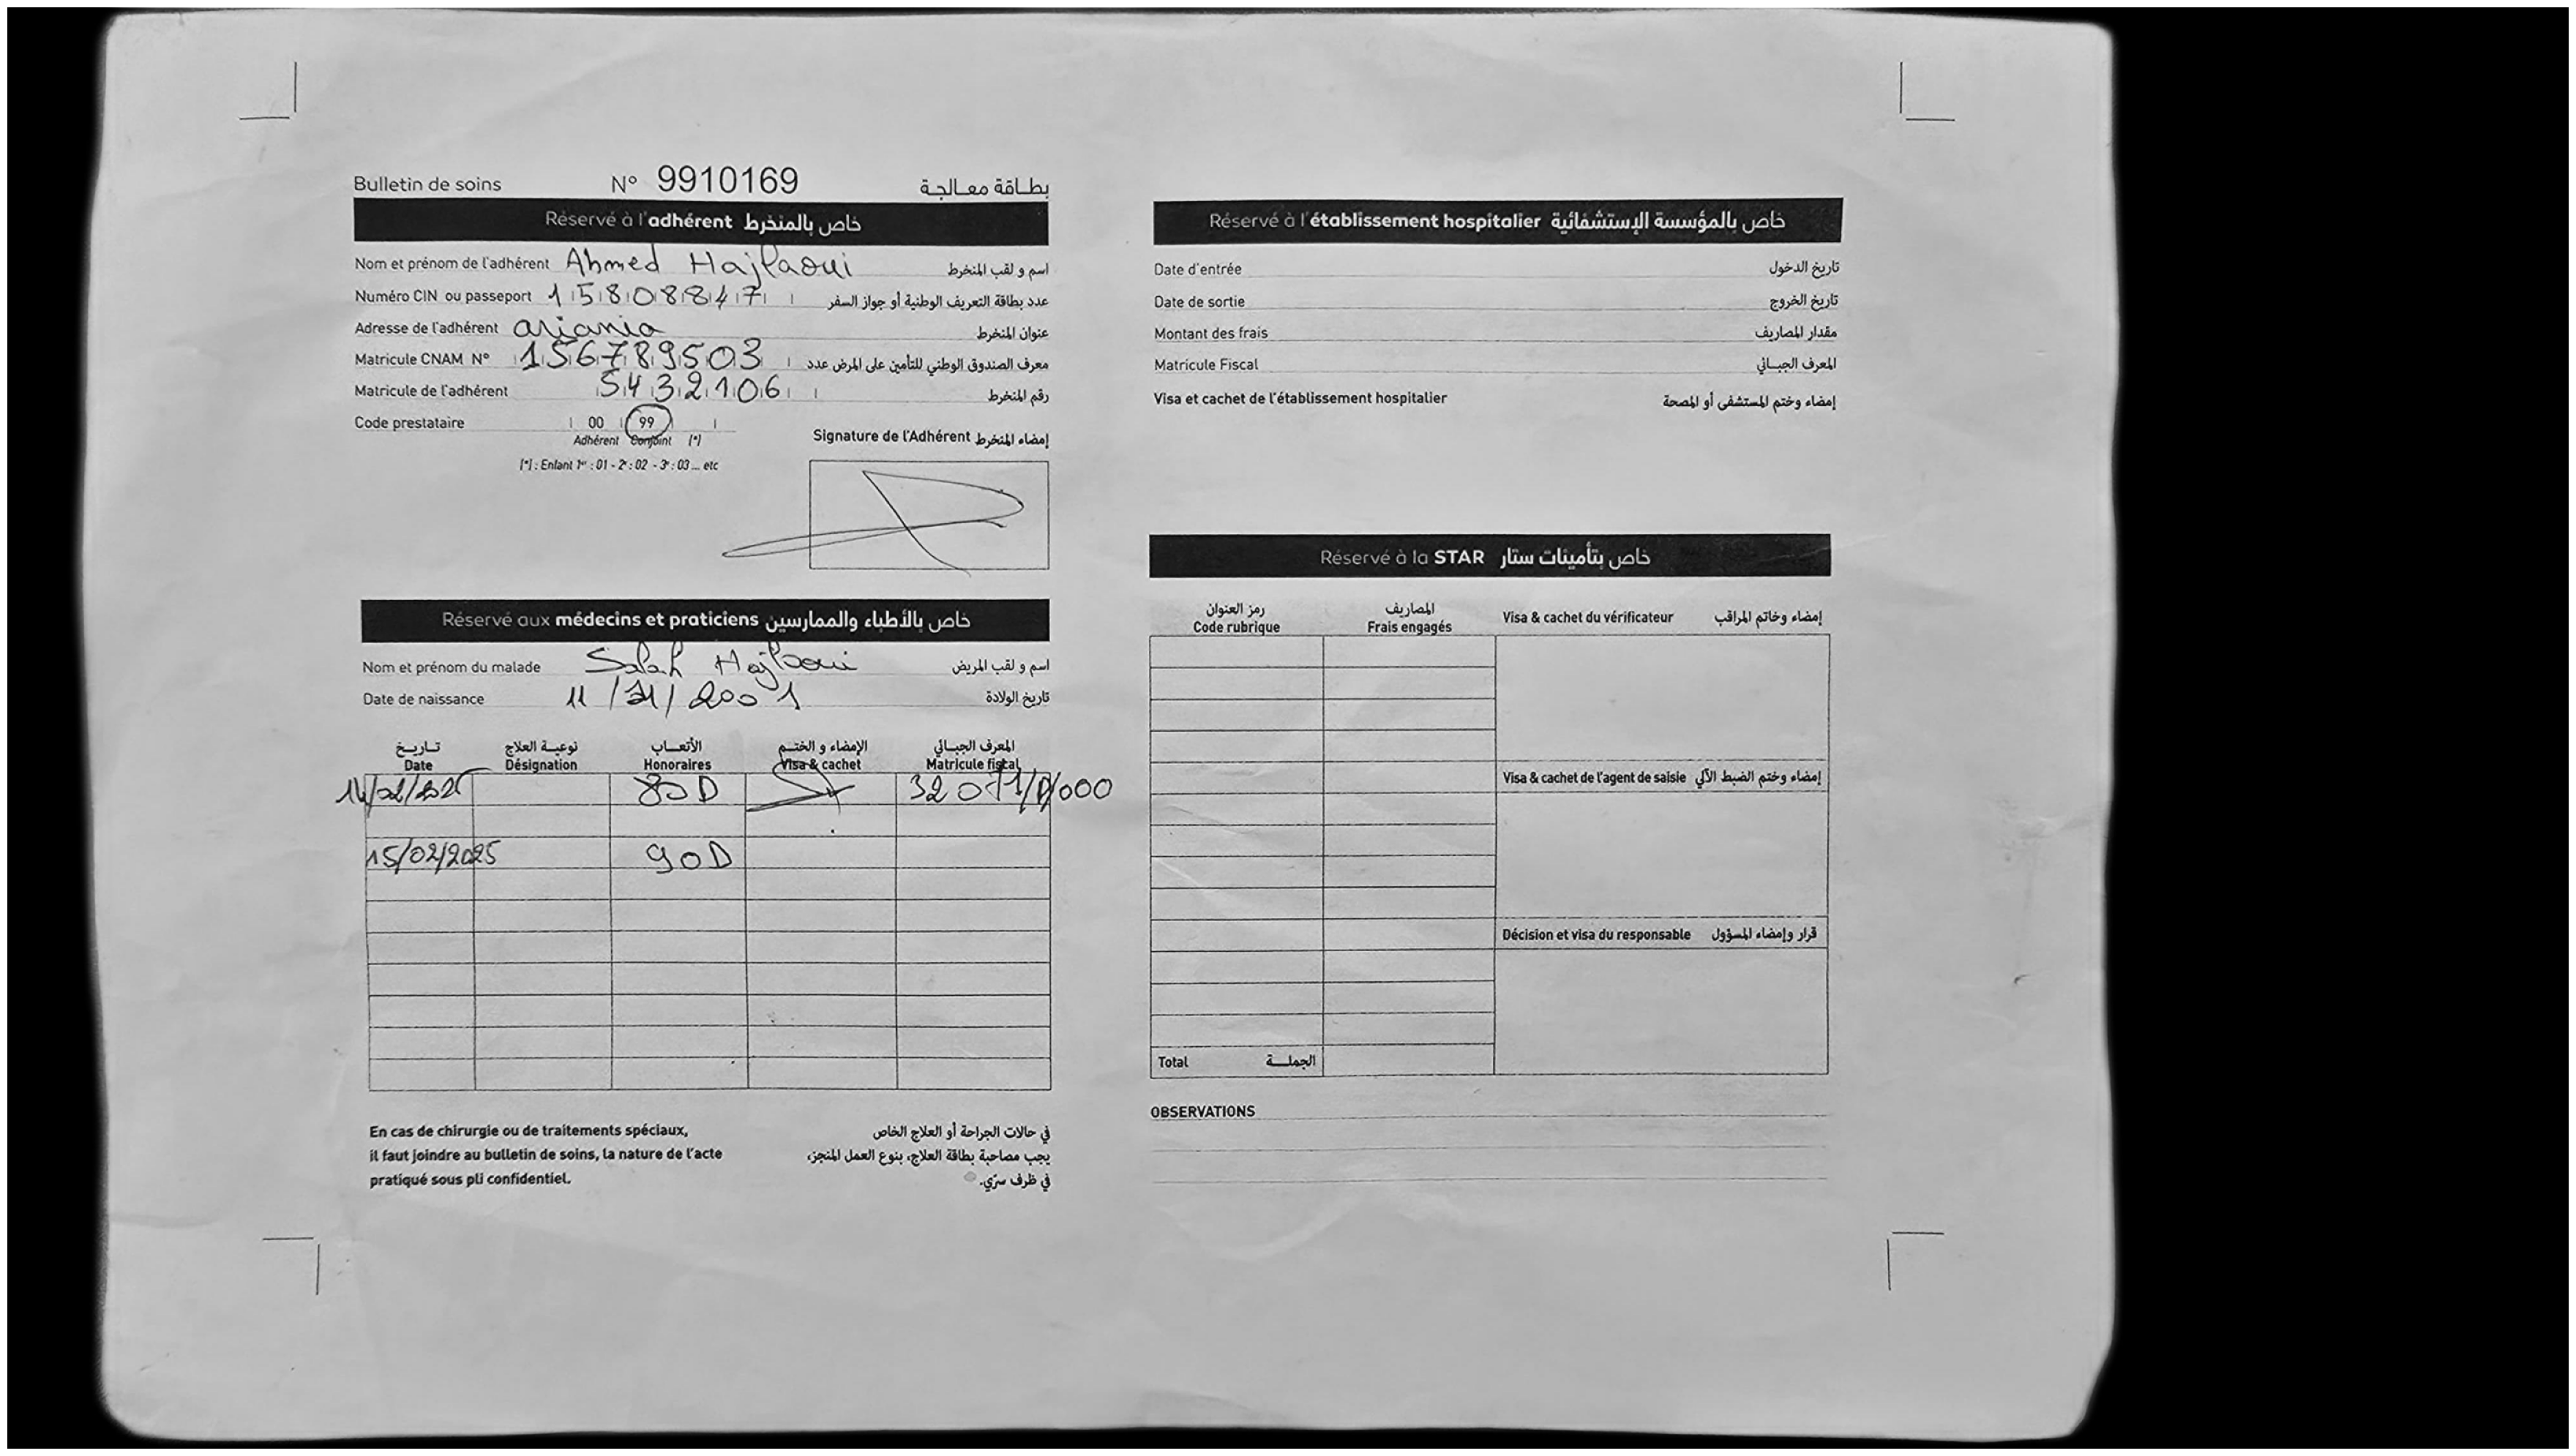

In [15]:
import cv2
import os
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt

# 🔍 Affichage de l’image traitée
def display(im_path, scale_percent=70):
    img = cv2.imread(im_path)
    new_width = int(img.shape[1] * scale_percent / 100)
    new_height = int(img.shape[0] * scale_percent / 100)
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    dpi = 80
    figsize = new_width / float(dpi), new_height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(resized_img_rgb, cmap='gray')
    plt.show()

# ✨ Traitement d’une image unique
def process_single_image(input_image_path, output_image_path):
    print(f"\n🚀 Traitement de l’image : {input_image_path}")

    image_type = is_scan_final_smart(input_image_path, show_debug=True)
    print(f"\n🧠 Type détecté : {image_type.upper()}")

    if image_type == "photo":
        # Suppression de fond si c’est une photo
        input_image = Image.open(input_image_path)
        output_image = remove(input_image)
        output_image = output_image.convert("RGB")  # This line was added
        output_image.save(output_image_path)

        # Conversion en niveaux de gris
        img = cv2.imread(output_image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(output_image_path, gray)

    else:
        # Si c’est un scan, juste conversion en niveaux de gris
        img = cv2.imread(input_image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(output_image_path, gray)

    # Affichage du résultat
    display(output_image_path)

# 🔽 Spécifie ici les chemins d’entrée et de sortie
input_path = "image_corrigé_inclinaison_apres_orientation.jpg"
output_path = "image_apres_background_2.jpg"

# 🔁 Traitement
process_single_image(input_path, output_path)

In [16]:
import cv2
import numpy as np
import os

def uniform_contrast_brightness(img, alpha=1.0, beta=50, clahe_clip_limit=2.0, denoise_h=10):
    """
    Enhance an image to resemble a high-quality scan with adaptive contrast, brightness,
    noise reduction, sharpening, and crop to the entire white paper for any photo.

    Parameters:
    - img: Input image (BGR format)
    - alpha: Contrast control (1.0 is no change, >1.0 increases contrast)
    - beta: Brightness control (positive increases brightness)
    - clahe_clip_limit: Clip limit for CLAHE (controls contrast enhancement strength)
    - denoise_h: Strength of denoising filter

    Returns:
    - Enhanced image containing the entire paper
    """
    # Step 1: Preprocess the image for better edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply strong Gaussian blur to reduce noise and shadows
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)

    # Step 2: Enhance contrast dynamically based on image
    clahe_pre = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    contrasted = clahe_pre.apply(blurred)

    # Step 3: Use adaptive thresholding with dynamic parameters
    block_size = min(51, max(11, img.shape[0] // 20))  # Adjust based on image height
    c_value = max(10, min(30, img.shape[0] // 50))     # Adjust based on image height
    thresh = cv2.adaptiveThreshold(contrasted, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, c_value)
    print(f"BlockSize : {block_size}, CValue : {c_value}")

    # Step 4: Apply morphological operations with dynamic kernel
    kernel_size = min(21, max(5, img.shape[0] // 50))
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)

    # Step 5: Find contours to detect the paper
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get the largest contour (assumed to be the paper)
        largest_contour = max(contours, key=cv2.contourArea)

        # Approximate the contour to a quadrilateral
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Ensure we have a quadrilateral (4 points) to apply perspective transform
        if len(approx) == 4:
            # Get the points of the quadrilateral
            src_points = np.float32([approx[i][0] for i in range(4)])

            # Define the destination points to fit the full paper into the output image
            width = max(np.linalg.norm(src_points[0] - src_points[1]), np.linalg.norm(src_points[2] - src_points[3]))
            height = max(np.linalg.norm(src_points[0] - src_points[3]), np.linalg.norm(src_points[1] - src_points[2]))
            dst_points = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

            # Apply perspective transform to correct the paper's perspective
            matrix = cv2.getPerspectiveTransform(src_points, dst_points)
            paper_img = cv2.warpPerspective(img, matrix, (int(width), int(height)))
        else:
            # If not a quadrilateral, fall back to bounding rectangle with adaptive margin
            x, y, w, h = cv2.boundingRect(largest_contour)
            margin = max(50, min(100, img.shape[0] // 20))  # Dynamic margin based on image height
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(img.shape[1] - x, w + 2 * margin)
            h = min(img.shape[0] - y, h + 2 * margin)
            paper_img = img[y:y+h, x:x+w]

        # Use the corrected image as the base for further processing
        final_img = paper_img
    else:
        # If no contours are found, use a large portion of the image as fallback
        margin = max(50, img.shape[0] // 10)
        x, y = margin, margin
        w = img.shape[1] - 2 * margin
        h = img.shape[0] - 2 * margin
        paper_img = img[y:y+h, x:x+w]
        final_img = paper_img

    # Step 6: Noise reduction using Non-Local Means Denoising
    denoised = cv2.fastNlMeansDenoisingColored(final_img, h=denoise_h, templateWindowSize=7, searchWindowSize=21)

    # Step 7: Apply adaptive histogram equalization (CLAHE) for better contrast
    clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=(8, 8))
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    clahe_img = clahe.apply(gray)

    # Step 8: Normalize brightness
    mean_brightness = np.mean(clahe_img)
    target_brightness = 120.0  # Adjusted for scan-like brightness
    brightness_shift = target_brightness - mean_brightness
    normalized = cv2.convertScaleAbs(denoised, alpha=1.0, beta=brightness_shift)

    # Step 9: Apply contrast and brightness adjustments
    enhanced = cv2.convertScaleAbs(normalized, alpha=alpha, beta=beta)

    # Step 10: Sharpen image with adaptive kernel
    kernel = np.array([[-0.5, -0.5, -0.5],
                       [-0.5,  5.0, -0.5],
                       [-0.5, -0.5, -0.5]])
    sharpened = cv2.filter2D(enhanced, -1, kernel)

    # Step 11: Convert to grayscale for scan-like effect
    final_gray = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)

    # Step 12: Apply slight Gaussian blur to smooth any over-sharpening
    final = cv2.GaussianBlur(final_gray, (3, 3), 0)

    return final

if __name__ == "__main__":
    image_path = "image_apres_background_2.jpg"
    output_path = "img_brightness_corrige.jpg"

    # Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("❌ Image not found.")

    # Process image
    final = uniform_contrast_brightness(img, alpha=1.2, beta=40, clahe_clip_limit=2.5, denoise_h=8)
    cv2.imwrite(output_path, final)
    print(f"✅ Enhanced image saved: {output_path}")

BlockSize : 51, CValue : 30
✅ Enhanced image saved: img_brightness_corrige.jpg


In [17]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [18]:
import cv2
import os
from roboflow import Roboflow

# 🔐 Connexion à Roboflow
rf = Roboflow(api_key="6PR63Gl5mDpPl7PgQInQ")

# 📦 Chargement du projet et du modèle
workspace = rf.workspace("mediscan-co6dt")
project = workspace.project("zdczdcmlgr-zeff-w1a7b")
model = project.version(8).model

# 🖼️ Spécifier le chemin de l'image à traiter
image_path = "img_brightness_corrige.jpg"  # <-- remplace ce nom
output_path = "segmented_mon_image.jpg"

# 📥 Chargement de l'image
image = cv2.imread(image_path)

try:
    # 🔍 Prédiction
    response = model.predict(image_path).json()
    detections = response["predictions"]

    for detection in detections:
        x, y = int(detection["x"]), int(detection["y"])
        width, height = int(detection["width"]), int(detection["height"])

        # 🎨 Couleur blanche
        color = (255, 255, 255)

        # 📦 Dessin du rectangle
        cv2.rectangle(image, (x - width // 2, y - height // 2),
                      (x + width // 2, y + height // 2), color, 2)

    # 💾 Sauvegarde de l'image annotée
    cv2.imwrite(output_path, image)
    print(f"✅ Image traitée et sauvegardée : {output_path}")

except Exception as e:
    print(f"❌ Erreur lors du traitement de l'image :", e)

loading Roboflow workspace...
loading Roboflow project...
✅ Image traitée et sauvegardée : segmented_mon_image.jpg


In [19]:
import os
import cv2
from roboflow import Roboflow
import shutil

# 📥 Chemin vers une seule image
image_path = "segmented_mon_image.jpg"  # <- Remplace par le nom exact

# 📤 Dossier de sortie
output_dir = "extracted_all_segments"

# Vérifier si output_folder existe, le supprimer et créer un nouveau
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Supprime le dossier et tout son contenu
    print(f"🗑️ Ancien dossier {output_dir} supprimé.")
os.makedirs(output_dir, exist_ok=True)
print(f"📁 Nouveau dossier {output_dir} créé.")

# 🔐 Connexion à Roboflow
rf = Roboflow(api_key="6PR63Gl5mDpPl7PgQInQ")
model = rf.workspace("mediscan-co6dt").project("zdczdcmlgr-zeff-w1a7b").version(8).model

# 🖼️ Chargement de l'image
image = cv2.imread(image_path)
filename = os.path.basename(image_path)
global_segment_index = 1

try:
    # 🔍 Prédiction
    response = model.predict(image_path).json()
    detections = response["predictions"]

    for detection in detections:
        class_name = detection["class"]
        x, y = int(detection["x"]), int(detection["y"])
        width, height = int(detection["width"]), int(detection["height"])

        # 🟦 Calcul des coordonnées du rectangle
        x1 = max(x - width // 2, 0)
        y1 = max(y - height // 2, 0)
        x2 = min(x + width // 2, image.shape[1])
        y2 = min(y + height // 2, image.shape[0])

        # ✂️ Découpage
        cropped_segment = image[y1:y2, x1:x2]

        # 💾 Sauvegarde
        segment_filename = f"{global_segment_index}_{class_name.replace(' ', '_')}.jpg"
        segment_path = os.path.join(output_dir, segment_filename)
        cv2.imwrite(segment_path, cropped_segment)

        global_segment_index += 1

    print(f"✅ {global_segment_index - 1} segments extraits et sauvegardés dans : {output_dir}")

except Exception as e:
    print(f"❌ Erreur lors du traitement de l’image {filename} :", e)


📁 Nouveau dossier extracted_all_segments créé.
loading Roboflow workspace...
loading Roboflow project...
✅ 12 segments extraits et sauvegardés dans : extracted_all_segments


In [20]:
import cv2
import numpy as np
import os
import shutil
def process_image(image_path):
    """Process a single image to clean text"""
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ Could not read image: {image_path}")
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Otsu's thresholding (white background, black text)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Cleaning: erosion to refine text
    kernel = np.ones((1, 1), np.uint8)
    eroded = cv2.erode(thresh, kernel, iterations=1)

    # Optional: slight sharpening
    sharpen_kernel = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    sharpened = cv2.filter2D(eroded, -1, sharpen_kernel)

    return sharpened

# Input and output folders
input_folder = "/content/extracted_all_segments"  # Replace with your input folder path
output_folder = "/content/segments_avec_pretraitement"  # Replace with your output folder path

# Vérifier si output_folder existe, le supprimer et créer un nouveau
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)  # Supprime le dossier et tout son contenu
    print(f"🗑️ Ancien dossier {output_folder} supprimé.")
os.makedirs(output_folder, exist_ok=True)
print(f"📁 Nouveau dossier {output_folder} créé.")

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Process all images in input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, f"cleaned_{filename}")

        # Process the image
        cleaned_image = process_image(input_path)

        if cleaned_image is not None:
            # Save the cleaned image
            cv2.imwrite(output_path, cleaned_image)
            print(f"✅ Processed and saved: {output_path}")

print("\n🎉 All images processed!")

📁 Nouveau dossier /content/segments_avec_pretraitement créé.
✅ Processed and saved: /content/segments_avec_pretraitement/cleaned_9_honoraire.jpg
✅ Processed and saved: /content/segments_avec_pretraitement/cleaned_12_honoraire.jpg
✅ Processed and saved: /content/segments_avec_pretraitement/cleaned_7_cin_ou_passport.jpg
✅ Processed and saved: /content/segments_avec_pretraitement/cleaned_4_signature.jpg
✅ Processed and saved: /content/segments_avec_pretraitement/cleaned_2_date_maladie.jpg
✅ Processed and saved: /content/segments_avec_pretraitement/cleaned_5_date_maladie.jpg
✅ Processed and saved: /content/segments_avec_pretraitement/cleaned_3_nom_prenom_adherent.jpg
✅ Processed and saved: /content/segments_avec_pretraitement/cleaned_10_matricule_adherent.jpg
✅ Processed and saved: /content/segments_avec_pretraitement/cleaned_1_matricule_cnam.jpg
✅ Processed and saved: /content/segments_avec_pretraitement/cleaned_8_date_naissiance.jpg
✅ Processed and saved: /content/segments_avec_pretraite

In [21]:
import cv2
import numpy as np
import os
from glob import glob
import shutil
# Input and output folders
input_folder = "segments_avec_pretraitement"
output_folder = "/content/segments_avec_pretraitement_2"

# Vérifier si output_folder existe, le supprimer et créer un nouveau
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)  # Supprime le dossier et tout son contenu
    print(f"🗑️ Ancien dossier {output_folder} supprimé.")
os.makedirs(output_folder, exist_ok=True)
print(f"📁 Nouveau dossier {output_folder} créé.")

# Collect all .jpg images
image_paths = glob(os.path.join(input_folder, "*.jpg"))
if not image_paths:
    raise Exception("❌ Aucune image .jpg trouvée dans le dossier.")

for image_path in image_paths:
    filename = os.path.basename(image_path)
    print(f"🔧 Traitement de : {filename}")

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Impossible de charger {filename}")
        continue

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Contrast enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_clahe = clahe.apply(gray)

    # Denoising (gentle)
    denoised = cv2.fastNlMeansDenoising(gray_clahe, None, h=20, templateWindowSize=7, searchWindowSize=21)

    # Adaptive Thresholding (conservative)
    thresh = cv2.adaptiveThreshold(
        denoised, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 31, 10
    )

    # Line removal
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))

    h_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, h_kernel, iterations=1)
    v_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, v_kernel, iterations=1)
    all_lines = cv2.bitwise_or(h_lines, v_lines)

    # Remove detected lines from the thresholded image
    text_only = cv2.subtract(thresh, all_lines)

    # Clean isolated noise without damaging handwriting
    clean = cv2.morphologyEx(text_only, cv2.MORPH_OPEN, np.ones((1, 1), np.uint8), iterations=1)

    # Invert: black text on white
    final = cv2.bitwise_not(clean)

    # Save result
    output_path = os.path.join(output_folder, f"cleaned_{filename}")
    cv2.imwrite(output_path, final)
    print(f"✅ Sauvegardé : {output_path}")

print("🎉 Tous les fichiers ont été traités.")


📁 Nouveau dossier /content/segments_avec_pretraitement_2 créé.
🔧 Traitement de : cleaned_2_date_maladie.jpg
✅ Sauvegardé : /content/segments_avec_pretraitement_2/cleaned_cleaned_2_date_maladie.jpg
🔧 Traitement de : cleaned_6_code.jpg
✅ Sauvegardé : /content/segments_avec_pretraitement_2/cleaned_cleaned_6_code.jpg
🔧 Traitement de : cleaned_9_honoraire.jpg
✅ Sauvegardé : /content/segments_avec_pretraitement_2/cleaned_cleaned_9_honoraire.jpg
🔧 Traitement de : cleaned_4_signature.jpg
✅ Sauvegardé : /content/segments_avec_pretraitement_2/cleaned_cleaned_4_signature.jpg
🔧 Traitement de : cleaned_11_nom_prenom_malade.jpg
✅ Sauvegardé : /content/segments_avec_pretraitement_2/cleaned_cleaned_11_nom_prenom_malade.jpg
🔧 Traitement de : cleaned_12_honoraire.jpg
✅ Sauvegardé : /content/segments_avec_pretraitement_2/cleaned_cleaned_12_honoraire.jpg
🔧 Traitement de : cleaned_8_date_naissiance.jpg
✅ Sauvegardé : /content/segments_avec_pretraitement_2/cleaned_cleaned_8_date_naissiance.jpg
🔧 Traitement 

In [25]:
####################################  badelet ken hethhaaaaa  #############
import cv2
import numpy as np
import os
from glob import glob
import shutil

# Input and output folders
input_folder = "/content/segments_avec_pretraitement_2"
output_folder = "/content/segments_avec_pretraitement_3"

# Check if output_folder exists, delete it, and create a new one
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)  # Delete the folder and its contents
    print(f"🗑️ Old folder {output_folder} deleted.")
os.makedirs(output_folder, exist_ok=True)
print(f"📁 New folder {output_folder} created.")

# Collect all .jpg images
image_paths = glob(os.path.join(input_folder, "*.jpg"))
if not image_paths:
    raise Exception("❌ No .jpg images found in the folder.")

# Process each image
for image_path in image_paths:
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, filename)  # Keep original filename

    # Check if filename contains "nom" or "adresse" (case-insensitive)
    if "nom" in filename.lower() or "adresse" in filename.lower():
        print(f"🔧 Enhanced preprocessing for: {filename}")

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Failed to load {filename}")
            continue

        # ====== ENHANCEMENT PHASE ======
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Strong CLAHE for better contrast
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(12, 12))
        enhanced = clahe.apply(gray)

        # Advanced denoising (preserve edges)
        denoised = cv2.fastNlMeansDenoising(enhanced, None, h=25,
                                          templateWindowSize=9,
                                          searchWindowSize=25)

        # ====== TEXT EXTRACTION ======
        # Smart thresholding
        thresh = cv2.adaptiveThreshold(
            denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, 45, 12
        )

        # ====== NOISE REMOVAL ======
        # Remove small noise (white specks)
        noise_kernel = np.ones((2, 2), np.uint8)
        clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, noise_kernel, iterations=1)

        # Remove large background noise (black holes)
        bg_clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE,
                                  np.ones((3, 3), np.uint8),
                                  iterations=1)

        # ====== TEXT ENHANCEMENT ======
        # Slightly thicken text (fill small gaps)
        text_kernel = np.ones((2, 2), np.uint8)
        thickened = cv2.dilate(bg_clean, text_kernel, iterations=1)

        # Smooth text edges
        smoothed = cv2.medianBlur(thickened, 3)

        # ====== FINAL TOUCHES ======
        # Invert to black text on white
        final = cv2.bitwise_not(smoothed)

        # Ultra-clean background
        final = cv2.GaussianBlur(final, (3, 3), 0)
        final[final > 200] = 255  # Force pure white background

        # Save result
        cv2.imwrite(output_path, final)
        print(f"✅ Saved (enhanced): {output_path}")
    else:
        # Copy non-"nom" or non-"adresse" images as-is
        print(f"📄 Copying unchanged: {filename}")
        shutil.copy(image_path, output_path)
        print(f"✅ Saved (copied): {output_path}")

print("🎉 All files have been processed. 'nom' or 'adresse' images enhanced, others copied unchanged!")

🗑️ Old folder /content/segments_avec_pretraitement_3 deleted.
📁 New folder /content/segments_avec_pretraitement_3 created.
📄 Copying unchanged: cleaned_cleaned_7_cin_ou_passport.jpg
✅ Saved (copied): /content/segments_avec_pretraitement_3/cleaned_cleaned_7_cin_ou_passport.jpg
📄 Copying unchanged: cleaned_cleaned_5_date_maladie.jpg
✅ Saved (copied): /content/segments_avec_pretraitement_3/cleaned_cleaned_5_date_maladie.jpg
📄 Copying unchanged: cleaned_cleaned_10_matricule_adherent.jpg
✅ Saved (copied): /content/segments_avec_pretraitement_3/cleaned_cleaned_10_matricule_adherent.jpg
📄 Copying unchanged: cleaned_cleaned_8_date_naissiance.jpg
✅ Saved (copied): /content/segments_avec_pretraitement_3/cleaned_cleaned_8_date_naissiance.jpg
📄 Copying unchanged: cleaned_cleaned_9_honoraire.jpg
✅ Saved (copied): /content/segments_avec_pretraitement_3/cleaned_cleaned_9_honoraire.jpg
📄 Copying unchanged: cleaned_cleaned_6_code.jpg
✅ Saved (copied): /content/segments_avec_pretraitement_3/cleaned_clea

# classification du langue

In [26]:
# ====== MODEL INTEGRATION FOR LANGUAGE CLASSIFICATION ======
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import shutil
import os
import cv2
from PIL import Image
import shutil
# Define the folder containing images to classify (output from previous pipeline)
input_folder = "/content/segments_avec_pretraitement_3"
# Define output directories for classified images
output_french = "/content/output_french"
output_arabic = "/content/output_arabic"

# Vérifier si output_folder existe, le supprimer et créer un nouveau
if os.path.exists(output_french):
    shutil.rmtree(output_french)  # Supprime le dossier et tout son contenu
    print(f"🗑️ Ancien dossier {output_french} supprimé.")
os.makedirs(output_french, exist_ok=True)
print(f"📁 Nouveau dossier {output_french} créé.")


if os.path.exists(output_arabic):
    shutil.rmtree(output_arabic)  # Supprime le dossier et tout son contenu
    print(f"🗑️ Ancien dossier {output_arabic} supprimé.")
os.makedirs(output_arabic, exist_ok=True)
print(f"📁 Nouveau dossier {output_arabic} créé.")



# Load the pre-trained ResNet18 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=False)  # Load without pre-trained weights
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # 2 classes: arabe, francais
# Assuming 'resnet18_lang_classifier.pth' is in the current directory
# If not, adjust the path accordingly
model.load_state_dict(torch.load('resnet18_lang_classifier.pth', map_location=device))
model = model.to(device)
model.eval()

# Define test transformations (same as used during training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Filter images containing specific substrings
target_substrings = ["nom_prenom_adherent", "adresse_adherent", "nom_prenom_malade"]
target_images = [
    img_name for img_name in os.listdir(output_folder)
    if img_name.lower().endswith('.jpg') and
    any(substring in img_name for substring in target_substrings)
]

if not target_images:
    print("❌ Aucune image correspondant aux critères trouvée dans", output_folder)


# Label mapping
label_map = {'arabe': 0, 'francais': 1}

# Function to classify and copy images
def classify_images(model, image_folder, target_images, transform, device, output_french, output_arabic, label_map):
    image_names = []
    predictions = []

    for img_name in target_images:
        img_path = os.path.join(image_folder, img_name)
        if not os.path.exists(img_path):
            print(f"❌ Image {img_name} non trouvée dans {image_folder}")
            continue

        # Load image with OpenCV and convert to RGB for PIL
        image = cv2.imread(img_path)
        if image is None:
            print(f"❌ Impossible de charger {img_name}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        # Apply transformations and prepare for model
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            pred = predicted.item()

        # Copy to appropriate folder based on prediction
        if pred == label_map['francais']:
            shutil.copy(img_path, os.path.join(output_french, img_name))
            print(f"✅ Image {img_name} classée comme français, copiée dans {output_french}")
        elif pred == label_map['arabe']:
            shutil.copy(img_path, os.path.join(output_arabic, img_name))
            print(f"✅ Image {img_name} classée comme arabe, copiée dans {output_arabic}")

        image_names.append(img_name)
        predictions.append(pred)

    return image_names, predictions

# Run classification on specified images
print("\n--- Classification des images spécifiées ---")
classified_images, preds = classify_images(
    model, output_folder, target_images, test_transform, device,
    output_french, output_arabic, label_map
)

print("\n🎉 Classification terminée !")

🗑️ Ancien dossier /content/output_french supprimé.
📁 Nouveau dossier /content/output_french créé.
🗑️ Ancien dossier /content/output_arabic supprimé.
📁 Nouveau dossier /content/output_arabic créé.

--- Classification des images spécifiées ---
✅ Image cleaned_cleaned_3_nom_prenom_adherent.jpg classée comme français, copiée dans /content/output_french
✅ Image cleaned_cleaned_11_nom_prenom_malade.jpg classée comme français, copiée dans /content/output_french

🎉 Classification terminée !


OCR CRNN

In [29]:
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
from IPython.display import display  # For Jupyter/Colab
import shutil

# ---- Define paths ----
base_input_folder = "/content/segments_avec_pretraitement_3"
output_french_folder = "/content/output_french"
new_input_folder = "/content/combined_input_for_crnn"

# Create new input folder
if os.path.exists(new_input_folder):
    shutil.rmtree(new_input_folder)
os.makedirs(new_input_folder, exist_ok=True)
print(f"📁 Created new input folder: {new_input_folder}")

# Copy images from segments_avec_pretraitement_3 that do NOT contain "nom_prenom" or "adresse"
excluded_substrings = ["nom_prenom", "adresse"]
for img_name in os.listdir(base_input_folder):
    if img_name.lower().endswith('.jpg') and not any(substring in img_name for substring in excluded_substrings):
        src_path = os.path.join(base_input_folder, img_name)
        dst_path = os.path.join(new_input_folder, img_name)
        shutil.copy(src_path, dst_path)
        print(f"✅ Copied {img_name} from {base_input_folder} to {new_input_folder}")

# Copy all images from output_french
if os.path.exists(output_french_folder):
    for img_name in os.listdir(output_french_folder):
        if img_name.lower().endswith('.jpg'):
            src_path = os.path.join(output_french_folder, img_name)
            dst_path = os.path.join(new_input_folder, img_name)
            shutil.copy(src_path, dst_path)
            print(f"✅ Copied {img_name} from {output_french_folder} to {new_input_folder}")
else:
    print(f"⚠️ Folder {output_french_folder} does not exist.")

# Check if any images were copied
if not os.listdir(new_input_folder):
    print(f"❌ No images copied to {new_input_folder}. Please check the source folders.")
    exit()

# ---- Model and vocab setup ----
VOCAB = "abcdefghijklmnopqrstuvwxyz0123456789 .,;'-/"
VOCAB_DICT = {c: i + 1 for i, c in enumerate(VOCAB)}  # 0 reserved for CTC blank
VOCAB_DICT["<blank>"] = 0
INV_VOCAB_DICT = {v: k for k, v in VOCAB_DICT.items()}

def text_to_int_sequence(text):
    text = str(text).lower()
    return [VOCAB_DICT.get(c, 0) for c in text]

def greedy_decode(log_probs, blank=0):
    argmaxes = torch.argmax(log_probs, dim=2)
    decoded_texts = []
    for seq in argmaxes:
        decoded = []
        prev = blank
        for idx in seq:
            idx = idx.item()
            if idx != prev and idx != blank:
                decoded.append(INV_VOCAB_DICT.get(idx, ''))
            prev = idx
        decoded_texts.append(''.join(decoded))
    return decoded_texts

# ---- Model definition ----
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(512, 512, 2, 1, 0), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.lstm1 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        conv = self.cnn(x)
        conv = conv.squeeze(2)
        conv = conv.permute(0, 2, 1)
        rnn_out, _ = self.lstm1(conv)
        rnn_out, _ = self.lstm2(rnn_out)
        output = self.fc(rnn_out)
        output = output.log_softmax(2)
        return output

# ---- Function to preprocess image for CRNN ----
def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert('L')
        max_width = 512
        height = 32
        w, h = image.size
        new_w = int(w * (height / h))
        image = image.resize((new_w, height), Image.BILINEAR)
        if new_w < max_width:
            new_img = Image.new('L', (max_width, height), color=0)
            new_img.paste(image, (0, 0))
            image = new_img
        else:
            image = image.resize((max_width, height), Image.BILINEAR)
        to_tensor = transforms.ToTensor()
        normalize = transforms.Normalize((0.5,), (0.5,))
        image_tensor = to_tensor(image)
        image_tensor = normalize(image_tensor)
        image_tensor = image_tensor.unsqueeze(0)
        return image_tensor
    except Exception as e:
        print(f"⚠️ Failed to preprocess {image_path}: {e}")
        return None

# ---- Function to process folder and generate tables ----
def process_folder_and_generate_tables(input_folder, model_path):
    # Load model
    num_classes = len(VOCAB_DICT)
    model = CRNN(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    # Field mapping from segmented names to document names
    field_mapping = {
        "nom_prenom_adherent": "Nom et Prénom de l'Adhérent",
        "cin_ou_passport": "Numéro CIN ou Passport",
        "adresse_adherent": "Adresse de l'Adhérent",
        "matricule_cnam": "Matricule CNAM n°",
        "matricule_adherent": "Matricule de l'Adhérent",
        "code": "CODE Prestataire",
        "signature": "Signature",
        "nom_prenom_malade": "Nom et Prénom du Malade",
        "date_naissance": "Date de Naissance",
        "date_naissiance": "Date de Naissance",  # Handle typo
        "date_maladie": "Date",
        "designation": "Désignation",
        "honoraire": "Honoraire",
        "cachet": "Cachet",
        "matricule_fiscale": "Matricule Fiscale"
    }

    # Define fields for each section
    adherent_fields = [
        "nom_prenom_adherent", "cin_ou_passport", "adresse_adherent",
        "matricule_cnam", "matricule_adherent", "code", "signature"
    ]
    medecin_fields = [
        "nom_prenom_malade", "date_naissance", "date_naissiance", "date_maladie",
        "designation", "honoraire", "cachet", "matricule_fiscale"
    ]
    table_fields = ["Date", "Désignation", "Honoraire", "Cachet", "Matricule Fiscale"]

    # Define desired order for fields
    adherent_order = [
        "Nom et Prénom de l'Adhérent",
        "Numéro CIN ou Passport",
        "Adresse de l'Adhérent",
        "Matricule CNAM n°",
        "Matricule de l'Adhérent",
        "CODE Prestataire",
        "Signature"
    ]
    medecin_order = [
        "Nom et Prénom du Malade",
        "Date de Naissance",
        "Date",
        "Désignation",
        "Honoraire",
        "Cachet",
        "Matricule Fiscale"
    ]

    # Initialize results
    adherent_results = []
    medecin_results = []
    has_signature = False
    has_cachet = False
    has_mf = False
    present_table_fields = set()
    date_maladie_count = 0  # Track multiple date_maladie instances

    # Collect all .jpg images
    image_paths = glob(os.path.join(input_folder, "*.jpg"))
    if not image_paths:
        print(f"❌ No .jpg images found in {input_folder}. Please check the folder path.")
        return

    for image_path in image_paths:
        filename = os.path.basename(image_path)
        # Extract field name (e.g., 'cleaned_cleaned_7_cin_ou_passport.jpg' -> 'cin_ou_passport')
        parts = filename.split('_')
        # Find the first non-'cleaned' and non-numeric part
        field_name = ''
        for i in range(len(parts)):
            if parts[i] != 'cleaned' and not parts[i].isdigit():
                field_name = '_'.join(parts[i:]).replace('.jpg', '')
                break
        if not field_name:
            print(f"⚠️ Could not extract field name from {filename}")
            continue

        # Debugging: Print extracted field name
        print(f"Processing {filename} -> Field: {field_name}")

        # Map to display name
        display_name = field_mapping.get(field_name, field_name)

        # Handle multiple date_maladie instances
        if field_name == "date_maladie":
            date_maladie_count += 1
            display_name = f"Date (Maladie {date_maladie_count})" if date_maladie_count > 1 else "Date"

        # Preprocess image
        image_tensor = preprocess_image(image_path)
        if image_tensor is None:
            continue

        # Predict text
        with torch.no_grad():
            output = model(image_tensor)
            pred_text = greedy_decode(output.cpu())[0]

        # Special handling for CODE Prestataire
        if field_name == "code":
            if any(x in pred_text.lower() for x in ["0", "00ent", "00"]):
                pred_text = "Adhérent"
            elif any(x in pred_text.lower() for x in ["9", "99"]):
                pred_text = "Conjoint"

        # Special handling for Signature and Cachet
        if field_name in ["signature", "cachet"]:
            pred_text = "✅ Present"

        # Special handling for Honoraire
        if field_name == "honoraire":
            pred_text = pred_text.strip().rstrip('.')
            if pred_text.lower().endswith(('d', 'dt', 'dT', 'Dt', 'DT')):
                base_text = pred_text.rstrip('dDtT').strip()
                pred_text = f"{base_text} DT"
            else:
                pred_text = f"{pred_text} DT"

        # Categorize fields
        result = {"Field": display_name, "Recognized Text": pred_text}
        if field_name in adherent_fields:
            adherent_results.append(result)
            print(f"Added to adherent_results: {display_name} -> {pred_text}")
        elif field_name in medecin_fields:
            medecin_results.append(result)
            print(f"Added to medecin_results: {display_name} -> {pred_text}")
            if display_name in table_fields or display_name.startswith("Date"):
                present_table_fields.add(display_name)
        else:
            print(f"Field {field_name} not categorized (Display: {display_name})")

        # Check for specific fields
        if field_name == "signature":
            has_signature = True
        if field_name == "cachet":
            has_cachet = True
        if field_name == "matricule_fiscale":
            has_mf = True

    # Sort results according to desired order
    def sort_results(results, order):
        order_dict = {field: idx for idx, field in enumerate(order)}
        return sorted(results, key=lambda x: order_dict.get(x["Field"], len(order)))

    adherent_results = sort_results(adherent_results, adherent_order)
    medecin_results = sort_results(medecin_results, medecin_order)

    # Check for missing table fields
    missing_fields = [f for f in table_fields if f not in present_table_fields]
    if missing_fields:
        print(f"⚠️ Warning: The following table fields are missing: {', '.join(missing_fields)}")
    else:
        print("✅ All table fields are present.")

    # Create DataFrames
    df_adherent = pd.DataFrame(adherent_results)
    df_medecin = pd.DataFrame(medecin_results)

    # Field presence checks
    df_checks = pd.DataFrame([
        {"Field": "Signature", "Status": "✅ Present" if has_signature else "❌ Missing"},
        {"Field": "Cachet", "Status": "✅ Present" if has_cachet else "❌ Missing"},
        {"Field": "Matricule Fiscale (MF)", "Status": "✅ Present" if has_mf else "❌ Missing"}
    ])

    # Display results
    print("\n📊 Réservé à l'Adhérent:")
    if not df_adherent.empty:
        display(df_adherent)
    else:
        print("No fields found for Réservé à l'Adhérent.")

    print("\n📊 Réservé aux Médecins et Praticiens:")
    if not df_medecin.empty:
        display(df_medecin)
    else:
        print("No fields found for Réservé aux Médecins et Praticiens.")

    print("\n🔍 Field Presence Checks:")
    display(df_checks)

# ---- Main execution ----
input_folder = "/content/combined_input_for_crnn"
model_path = "crnn_finetuned.pth"

process_folder_and_generate_tables(input_folder, model_path)

📁 Created new input folder: /content/combined_input_for_crnn
✅ Copied cleaned_cleaned_7_cin_ou_passport.jpg from /content/segments_avec_pretraitement_3 to /content/combined_input_for_crnn
✅ Copied cleaned_cleaned_5_date_maladie.jpg from /content/segments_avec_pretraitement_3 to /content/combined_input_for_crnn
✅ Copied cleaned_cleaned_10_matricule_adherent.jpg from /content/segments_avec_pretraitement_3 to /content/combined_input_for_crnn
✅ Copied cleaned_cleaned_8_date_naissiance.jpg from /content/segments_avec_pretraitement_3 to /content/combined_input_for_crnn
✅ Copied cleaned_cleaned_9_honoraire.jpg from /content/segments_avec_pretraitement_3 to /content/combined_input_for_crnn
✅ Copied cleaned_cleaned_6_code.jpg from /content/segments_avec_pretraitement_3 to /content/combined_input_for_crnn
✅ Copied cleaned_cleaned_12_honoraire.jpg from /content/segments_avec_pretraitement_3 to /content/combined_input_for_crnn
✅ Copied cleaned_cleaned_1_matricule_cnam.jpg from /content/segments_av

Field Recognized Text
0  Nom et Prénom de l'Adhérent  ahmed hajlaoui
1       Numéro CIN ou Passport         5808847
2            Matricule CNAM n°       156789503
3      Matricule de l'Adhérent         5432106
4             CODE Prestataire        Conjoint
5                    Signature       ✅ Present


📊 Réservé aux Médecins et Praticiens:


Field Recognized Text
0  Nom et Prénom du Malade    slal halooui
1        Date de Naissance       1/31/2001
2                     Date      15/02/2025
3                Honoraire           80 DT
4                Honoraire           90 DT
5         Date (Maladie 2)        14/02/00


🔍 Field Presence Checks:


Field     Status
0               Signature  ✅ Present
1                  Cachet  ❌ Missing
2  Matricule Fiscale (MF)  ❌ Missing